In [1]:
import torch
import torch.nn.utils.prune as prune
from ultralytics import YOLO
from copy import deepcopy

In [2]:
model_sparse=YOLO("models/yolo11x_trained_pruned_local_structured_30_channel_mask.pt")
model_retrained=YOLO("../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_30_channel_mask/weights/best.pt")


In [3]:
pruned_state_dict = {}  # Store masks separately

for name, buf in model_sparse.named_buffers():
    if "mask" in name:  # Only save mask buffers
        pruned_state_dict[name] = buf.clone()  # Copy the mask tensor
        


In [4]:
# for name, buf in model_retrained.named_buffers():
#     if name in pruned_state_dict:  # Check if the mask exists in pruned model
#         buf.copy_(pruned_state_dict[name])  # Restore mask

# Manually zero out the pruned weights
with torch.no_grad():
    for name, param in model_retrained.named_parameters():
        mask_name = name.replace("weight", "weight_mask")  # Find corresponding mask
        if mask_name in pruned_state_dict:
            param *= pruned_state_dict[mask_name]  # Apply mask


In [5]:
for name, param in model_retrained.named_parameters():
    if "weight" in name:
        zero_count = (param == 0).sum().item()
        total_count = param.numel()
        sparsity = zero_count / total_count * 100
        print(f"{name}: {sparsity:.2f}% sparse")


model.model.0.conv.weight: 30.21% sparse
model.model.0.bn.weight: 0.00% sparse
model.model.1.conv.weight: 30.21% sparse
model.model.1.bn.weight: 0.00% sparse
model.model.2.cv1.conv.weight: 30.21% sparse
model.model.2.cv1.bn.weight: 0.00% sparse
model.model.2.cv2.conv.weight: 29.95% sparse
model.model.2.cv2.bn.weight: 0.00% sparse
model.model.2.m.0.cv1.conv.weight: 29.17% sparse
model.model.2.m.0.cv1.bn.weight: 0.00% sparse
model.model.2.m.0.cv2.conv.weight: 29.17% sparse
model.model.2.m.0.cv2.bn.weight: 0.00% sparse
model.model.2.m.0.cv3.conv.weight: 30.21% sparse
model.model.2.m.0.cv3.bn.weight: 0.00% sparse
model.model.2.m.0.m.0.cv1.conv.weight: 29.17% sparse
model.model.2.m.0.m.0.cv1.bn.weight: 0.00% sparse
model.model.2.m.0.m.0.cv2.conv.weight: 29.17% sparse
model.model.2.m.0.m.0.cv2.bn.weight: 0.00% sparse
model.model.2.m.0.m.1.cv1.conv.weight: 29.17% sparse
model.model.2.m.0.m.1.cv1.bn.weight: 0.00% sparse
model.model.2.m.0.m.1.cv2.conv.weight: 29.17% sparse
model.model.2.m.0.m.1

In [7]:
val_retrained = model_retrained.val(
    data="../datasets/cocoa_diseases/cocoa_dataset.yaml",
    imgsz=640,
    batch=4,  # Small batch size
    device=[0]  # GPU
)

Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


                   all         62        289   0.000517     0.0167    0.00029   7.56e-05
          phytophthora         30         39          0          0          0          0
               monilia         23         30          0          0          0          0
               healthy         52        220    0.00155       0.05    0.00087   0.000227
Speed: 1.6ms preprocess, 50.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val14


In [9]:
model_dense=YOLO("../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_30_channel_mask/weights/best.pt")

val_retrained = model_dense.val(
    data="../datasets/cocoa_diseases/cocoa_dataset.yaml",
    imgsz=640,
    batch=4,  # Small batch size
    device=[0] # GPU
)

Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.08it/s]


                   all         62        289      0.577      0.521      0.557      0.324
          phytophthora         30         39      0.531      0.513      0.472      0.289
               monilia         23         30      0.486        0.4      0.481      0.293
               healthy         52        220      0.714       0.65      0.719       0.39
Speed: 0.7ms preprocess, 48.9ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val15


#### Tutorial for PyTorch pruning: 
https://towardsdatascience.com/how-to-prune-neural-networks-with-pytorch-ebef60316b91
https://medium.com/data-scientists-diary/mastering-model-pruning-in-pytorch-789f4b3ef0be

# Pruning and other utility functions

In [2]:
def prune_model(model, amount=0.1, prune_type="unstructured", dim=0, rm_mask=True):
    """
    Prunes the model based on the specified prune_type.
    
    Args:
        model: The model to be pruned.
        amount: The amount of pruning to apply (e.g., fraction of weights to prune).
        prune_type: Type of pruning: "unstructured" or "structured".
        dim: Dimension along which to apply structured pruning (only for structured).
    
    Returns:
        model: The pruned model.
    """
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            print(f"Pruning module: {module}")
            
            if prune_type == "unstructured":
                # Apply unstructured pruning
                prune.l1_unstructured(module, name="weight", amount=amount)
            elif prune_type == "structured":
                # Apply structured pruning
                prune.ln_structured(module, name="weight", amount=amount, n=2, dim=dim)
            else:
                raise ValueError(f"Unsupported prune_type: {prune_type}")
        
            if rm_mask:
            # Remove the pruning mask and update the weights
                prune.remove(module, "weight")
    
    return model

# Dense model loading and validation

In [3]:
model=YOLO("../cocoa_diseases_yolo11x_dense/train_dense/weights/best.pt")
print(model.info())
torch_model=model.model

YOLO11x summary: 631 layers, 56,877,241 parameters, 0 gradients, 195.5 GFLOPs
(631, 56877241, 0, 195.46199040000002)


In [4]:
val_dense = model.val(
    data="../datasets/cocoa_diseases/cocoa_dataset.yaml",
    imgsz=640,
    batch=2,  # Small batch size
    device=[1,2]  # GPU
)

Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:1 (NVIDIA A16, 15000MiB)
                                                       CUDA:2 (NVIDIA A16, 15000MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]


                   all         62        289      0.735      0.648       0.73      0.506
          phytophthora         30         39      0.781      0.564      0.678        0.5
               monilia         23         30      0.653      0.767      0.752       0.56
               healthy         52        220      0.771      0.613       0.76      0.457
Speed: 2.1ms preprocess, 85.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/val2


# Post-train pruning

In [4]:
amount=[0.1,0.15,0.2,0.3,0.4,0.5]

## Local unstructured pruning

In [5]:

for value in amount:
    pruned_torch_model=prune_model(deepcopy(torch_model),prune_type='unstructured', amount=value)
#    print(pruned_torch_model.info())
    print(f"Model pruned by {int(value*100)}%.")
    model.model=pruned_torch_model
    model.save(f"models/yolo11x_trained_pruned_local_unstructured_{int(value*100)}.pt")
    print("Model saved.")

Pruning module: Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Pruning module: Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Pruning module: Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size

## Local structured pruning

### Channel-wise

In [5]:


for value in amount:
    pruned_torch_model=prune_model(deepcopy(torch_model), prune_type='structured', dim=0, amount=value)
#    print(pruned_torch_model.info())
    print(f"Model pruned by {int(value*100)}%.")
    model.model=pruned_torch_model
    model.save(f"models/yolo11x_trained_pruned_local_structured_{int(value*100)}_channel.pt")
    print("Model saved.")


Pruning module: Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Pruning module: Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Pruning module: Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size

In [5]:
pruned_torch_model=prune_model(deepcopy(torch_model), prune_type='structured', dim=0, amount=0.5)
#    print(pruned_torch_model.info())
print(f"Model pruned by {int(0.5*100)}%.")
model.model=pruned_torch_model
model.save(f"models/yolo11x_trained_pruned_local_structured_{int(0.5*100)}_channel.pt")
print("Model saved.")

Pruning module: Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Pruning module: Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Pruning module: Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size

### Neuron-wise

In [79]:


for value in amount:
    pruned_torch_model=prune_model(torch_model, prune_type='structured', dim=1, amount=value)
#    print(pruned_torch_model.info())
    print(f"Model pruned by {int(value*100)}%.")
    model.model=pruned_torch_model
    model.save(f"models/yolo11x_trained_pruned_local_structured_{int(value*100)}_neuron.pt")
    print("Model saved.")


Pruning module: Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Pruning module: Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Pruning module: Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Pruning module: Conv2d(96, 48, kernel_size

## Global pruning

## Combined pruning

# Sparsification visualization

In [14]:
# Load the sparsified model

#../cocoa_diseases_yolo11x_dense/train2/weights/best.pt
#models/yolo11x_trained_pruned_local_structured_30_channel_mask.pt

model = YOLO('models/yolo11x_trained_pruned_local_structured_30_channel.pt')
model.info()

YOLO11x summary: 631 layers, 56,877,241 parameters, 0 gradients, 195.5 GFLOPs


(631, 56877241, 0, 195.46199040000002)

In [65]:
pruned_channels = []
for i, module in enumerate(model.modules()):
    if isinstance(module, torch.nn.Conv2d):
        weight_tensor=module.weight
        for j,channel in enumerate(weight_tensor):
            if torch.all(channel==0):
                # pruned_channels.append(channel)
                print(j,"found empty channel")
                

2 found empty channel
4 found empty channel
5 found empty channel
7 found empty channel
12 found empty channel
14 found empty channel
22 found empty channel
23 found empty channel
24 found empty channel
25 found empty channel
27 found empty channel
30 found empty channel
42 found empty channel
44 found empty channel
47 found empty channel
49 found empty channel
51 found empty channel
59 found empty channel
63 found empty channel
69 found empty channel
71 found empty channel
74 found empty channel
75 found empty channel
76 found empty channel
78 found empty channel
79 found empty channel
85 found empty channel
91 found empty channel
93 found empty channel
0 found empty channel
1 found empty channel
4 found empty channel
6 found empty channel
7 found empty channel
12 found empty channel
14 found empty channel
19 found empty channel
20 found empty channel
21 found empty channel
27 found empty channel
28 found empty channel
33 found empty channel
35 found empty channel
37 found empty chann

In [71]:
for i, module in enumerate(model.modules()):
    if isinstance(module, torch.nn.Conv2d):
        weight_tensor=module.weight
        weight_tensor_nonzero=weight_tensor[weight_tensor.nonzero()]
        print(len(weight_tensor))

96
192
192
384


IndexError: index 48 is out of bounds for dimension 0 with size 48

In [65]:
import torch
import numpy as np

# Define the indices or ranges for backbone, neck, and head
backbone_range = range(0, 9)  # Layers 0-8 are backbone
neck_range = range(9, 23)     # Layers 9-22 are neck
head_range = range(23, len(model.model.model))  # Layers 23+ are head

# Initialize counters for zero weights and total weights
backbone_zero = 0
backbone_total = 0

neck_zero = 0
neck_total = 0

head_zero = 0
head_total = 0

# Iterate through the layers and collect weights into categories
for i, module in enumerate(model.modules()):  # Iterate over the components
    if isinstance(module, torch.nn.Conv2d):  # Ensure it's a Conv2D layer
        weights = module.weight.detach().cpu().numpy().flatten()  # Flatten the weights
        
        zero_count = np.sum(weights == 0)  # Count zero weights
        total_count = weights.size          # Total number of weights
        
        if i in backbone_range:
            backbone_zero += zero_count
            backbone_total += total_count
        elif i in neck_range:
            neck_zero += zero_count
            neck_total += total_count
        elif i in head_range:
            head_zero += zero_count
            head_total += total_count

# Calculate sparsity percentages
backbone_sparsity = (backbone_zero / backbone_total) * 100 if backbone_total > 0 else 0
neck_sparsity = (neck_zero / neck_total) * 100 if neck_total > 0 else 0
head_sparsity = (head_zero / head_total) * 100 if head_total > 0 else 0

# Display the sparsity results
print(f"Backbone Sparsity: {backbone_sparsity:.2f}% ({backbone_zero}/{backbone_total} weights are zero)")
print(f"Neck Sparsity: {neck_sparsity:.2f}% ({neck_zero}/{neck_total} weights are zero)")
print(f"Head Sparsity: {head_sparsity:.2f}% ({head_zero}/{head_total} weights are zero)")


Backbone Sparsity: 30.21% (50895/168480 weights are zero)
Neck Sparsity: 29.98% (56640/188928 weights are zero)
Head Sparsity: 29.17% (1344/4608 weights are zero)


# Fine-tuning (retraining with a lower learning rate and batch size for better generalization)

In [2]:
models=[
       "pruned_local_unstructured_50"]

for model_name in models:
    print(f"models/yolo11x_trained_{model_name}.pt")

models/yolo11x_trained_pruned_local_unstructured_50.pt


In [3]:
for model_name in models:
    model=YOLO(f"models/yolo11x_trained_{model_name}.pt")
# Use the model
    train_results = model.train(
        data = "../datasets/cocoa_diseases/cocoa_dataset.yaml",
        epochs=100,
        project="../cocoa_diseases_yolo11x_dense",
        name=f"train_{model_name}",
        plots=True,
        imgsz=640,
        lr0=0.001,   # default lr is 0.01
        batch=4,  # Small batch size
        device=[1],  # GPU
        workers=4  # Minimal number of workers
    )

New https://pypi.org/project/ultralytics/8.3.59 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:1 (Tesla T4, 14918MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=models/yolo11x_trained_pruned_local_unstructured_50.pt, data=../datasets/cocoa_diseases/cocoa_dataset.yaml, epochs=100, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=[1], workers=4, project=../cocoa_diseases_yolo11x_dense, name=train_pruned_local_unstructured_50, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, p

train: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/train.cache... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]
val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]


Plotting labels to ../cocoa_diseases_yolo11x_dense/train_pruned_local_unstructured_50/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to ../cocoa_diseases_yolo11x_dense/train_pruned_local_unstructured_50
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.51G      1.066     0.8552      1.172         22        640: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]

                   all         62        289    0.00125     0.0201   0.000203   4.84e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.31G      1.157     0.9217       1.23          9        640: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]

                   all         62        289    0.00574    0.00855   0.000384   9.43e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.32G      1.224      1.009      1.249         11        640: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]

                   all         62        289   0.000302     0.0101   0.000123   1.64e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.31G       1.27      1.074      1.296         13        640: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.81it/s]

                   all         62        289   0.000417     0.0111   0.000166   2.83e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.31G      1.261      1.068      1.293         21        640: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.76it/s]

                   all         62        289    0.00228     0.0171   0.000309   3.51e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.31G      1.282      1.035      1.315         21        640: 100%|██████████| 63/63 [00:19<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]

                   all         62        289    0.00186    0.00855   0.000315   8.08e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.32G      1.304       1.01      1.311         22        640: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all         62        289   0.000231     0.0101   0.000108   1.44e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.31G      1.255      1.009      1.283         19        640: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all         62        289   0.000624    0.00855   5.39e-05   5.39e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.31G      1.249      1.004      1.293          8        640: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all         62        289     0.0022    0.00855   0.000263   5.44e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.32G       1.27     0.9972       1.29         20        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all         62        289    0.00447     0.0282   0.000481   0.000151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.31G      1.251     0.9071      1.281         34        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all         62        289   0.000114     0.0111   6.07e-05   1.21e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.31G      1.274     0.9711      1.288         15        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all         62        289   9.27e-05    0.00855   5.02e-05      1e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.31G       1.26      0.953      1.255         27        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all         62        289    0.00037     0.0101   8.13e-05   8.13e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.31G      1.229     0.9354      1.257          5        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all         62        289    0.00259     0.0186   0.000268   0.000106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.32G      1.283     0.9662      1.306          9        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all         62        289    0.00677     0.0282   0.000806    0.00014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.31G      1.239     0.9437      1.265         26        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00178     0.0171   0.000336   7.09e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.31G      1.264      0.974      1.286          9        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00215     0.0256   0.000419   8.04e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.32G      1.212     0.8978      1.227         25        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all         62        289   0.000603     0.0111   0.000365   6.76e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.33G        1.2     0.8907      1.234          5        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all         62        289     0.0011    0.00855   0.000147   1.47e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.31G      1.148     0.8547      1.228         14        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all         62        289    0.00149    0.00855   0.000299   5.94e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.32G      1.194     0.8988      1.231         23        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all         62        289   0.000621    0.00855   0.000121   4.72e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       5.3G      1.189     0.9218      1.254          4        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all         62        289    0.00053    0.00855   0.000182   4.88e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.32G      1.187     0.9226      1.229         18        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all         62        289   0.000691    0.00855    5.8e-05   1.74e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.31G      1.159     0.8744       1.22         10        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all         62        289     0.0015     0.0171   0.000279   0.000113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.31G      1.155     0.8346       1.21          7        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all         62        289    0.00129    0.00855   9.22e-05   9.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.31G      1.158     0.8236      1.236         32        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all         62        289    0.00136     0.0186   0.000202   4.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.32G      1.165     0.8658      1.229         10        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all         62        289    0.00336     0.0256   0.000447   0.000114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.31G      1.148     0.8217      1.213         12        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all         62        289    0.00319     0.0272   0.000458   0.000224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.31G      1.139     0.7863      1.207         12        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all         62        289    0.00256     0.0272    0.00049   0.000124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.31G      1.117     0.7576      1.206         17        640: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all         62        289    0.00182     0.0171   0.000389   7.12e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.32G      1.135      0.794      1.199         37        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all         62        289    0.00386     0.0256   0.000555   8.24e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.31G      1.134     0.7848      1.186         17        640: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all         62        289     0.0015     0.0282   0.000317   3.67e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.32G      1.118     0.8002      1.198         26        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all         62        289   0.000941    0.00855      7e-05    1.4e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.32G      1.089     0.7495      1.179         11        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00293     0.0171   0.000369   9.44e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.32G      1.087     0.7619      1.187         10        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00188     0.0171   0.000346   0.000128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.31G      1.123     0.7451      1.181         36        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all         62        289    0.00133     0.0171   0.000201   3.58e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.31G      1.087     0.7352       1.16         29        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all         62        289    0.00175    0.00855    0.00029    5.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.33G      1.103     0.7609      1.211         10        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all         62        289    0.00134     0.0171   0.000176   3.52e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.31G      1.091     0.7406      1.183          6        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all         62        289    0.00102    0.00855   0.000187   6.15e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.32G      1.077     0.7309      1.161         20        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all         62        289   0.000868    0.00855   0.000157   1.57e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.32G      1.064     0.7336      1.157         16        640: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all         62        289    0.00234    0.00855   0.000221   2.21e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.31G      1.053     0.7234      1.171         18        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all         62        289    0.00425     0.0171   0.000623   0.000121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.32G      1.052     0.7051      1.147         27        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all         62        289    0.00263     0.0282   0.000556   0.000141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.31G      1.052     0.7275      1.148         32        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all         62        289    0.00324     0.0256   0.000485   8.04e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.32G      1.015     0.6856      1.131         21        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all         62        289    0.00741     0.0256   0.000948   0.000152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.32G      1.044     0.7205      1.162         18        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]

                   all         62        289     0.0072     0.0272   0.000824   9.57e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.32G      1.014     0.6984      1.148         21        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all         62        289    0.00414     0.0256   0.000526   9.13e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.31G      1.042     0.6892      1.134         21        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all         62        289    0.00149     0.0101   0.000314   9.04e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.32G     0.9937     0.6777      1.162         30        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all         62        289    0.00113     0.0101    0.00029    5.7e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       5.3G     0.9948     0.6903      1.143         11        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all         62        289    0.00371     0.0186   0.000356   7.12e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.31G     0.9813     0.6883      1.132         12        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all         62        289    0.00193     0.0101    0.00031   9.31e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.31G     0.9937     0.6662      1.127         12        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00189    0.00855   0.000147   1.47e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       5.3G     0.9576     0.6489      1.125         35        640: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all         62        289    0.00375     0.0201   0.000453   0.000169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.31G     0.9581     0.6389      1.117          9        640: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all         62        289    0.00383     0.0171    0.00072   0.000256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.31G     0.9564     0.6316      1.105          7        640: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all         62        289    0.00366     0.0256   0.000493    0.00013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.31G     0.9481       0.63      1.111         46        640: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all         62        289    0.00124     0.0171   0.000216   4.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.31G     0.9702     0.6253      1.106         30        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all         62        289    0.00279     0.0272   0.000415   0.000129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.31G      0.942     0.6114      1.093         32        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all         62        289    0.00367     0.0256   0.000508     0.0002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.32G      0.933     0.6086      1.097         19        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all         62        289    0.00137     0.0186   0.000248   0.000111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.31G     0.9279     0.5837      1.081         14        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all         62        289    0.00177     0.0101   0.000573   0.000143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.32G     0.9158     0.5879      1.066         26        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00296     0.0186   0.000514    9.5e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       5.3G     0.9478     0.5873      1.091          7        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all         62        289    0.00203     0.0101    0.00043   6.84e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.31G     0.8994     0.5836      1.071          7        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all         62        289    0.00343     0.0186   0.000457    0.00018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.32G     0.9081     0.5989      1.105         18        640: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all         62        289    0.00273     0.0272   0.000506   0.000115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.32G     0.8741      0.577      1.057         24        640: 100%|██████████| 63/63 [00:20<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all         62        289     0.0019    0.00855   0.000461   0.000102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.32G     0.8869     0.5701      1.058         27        640: 100%|██████████| 63/63 [00:20<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00272     0.0383   0.000538   0.000141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.31G     0.8789     0.5727      1.075         13        640: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all         62        289    0.00258     0.0272   0.000541   0.000151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.32G     0.8731     0.5536      1.071         14        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]

                   all         62        289    0.00219    0.00855   0.000482   0.000129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.31G     0.8518     0.5519      1.058          9        640: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all         62        289    0.00225     0.0272   0.000497   0.000112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.32G     0.8477     0.5377      1.043         19        640: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all         62        289    0.00387     0.0256   0.000616   0.000145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.32G      0.843     0.5318      1.066         14        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]

                   all         62        289    0.00324     0.0256   0.000585    0.00024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.32G     0.8271     0.5271      1.038         15        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all         62        289    0.00261     0.0201   0.000719   0.000174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.32G     0.8421     0.5419      1.055         20        640: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all         62        289    0.00354     0.0186   0.000562   0.000118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.32G     0.8238      0.521      1.037         15        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all         62        289     0.0066     0.0256   0.000935   0.000145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.32G     0.8296     0.5168      1.049         17        640: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all         62        289    0.00454     0.0256   0.000694   0.000197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.31G     0.7992     0.5087      1.032         13        640: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all         62        289    0.00417     0.0272   0.000619   0.000209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.31G     0.7888     0.4912      1.037         24        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all         62        289    0.00135     0.0186   0.000419   8.96e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.32G     0.7946     0.4984       1.03         14        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all         62        289   0.000863     0.0408   0.000503   8.32e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.33G     0.7828     0.5155      1.026         15        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00189     0.0101   0.000687   0.000118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.31G     0.8015     0.5136      1.032         26        640: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all         62        289    0.00276     0.0171   0.000496   7.68e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.31G     0.7756     0.4861      1.009         31        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all         62        289    0.00244     0.0186   0.000481   5.88e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.31G     0.7777     0.4772      1.025         13        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all         62        289    0.00362     0.0272   0.000592   0.000105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.31G     0.7655     0.4728      1.022         13        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

                   all         62        289    0.00323     0.0186   0.000559   0.000109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.32G     0.7573     0.4714      1.015         17        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all         62        289    0.00309     0.0186   0.000555    0.00016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.31G     0.7475     0.4815      1.012          9        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all         62        289    0.00336     0.0256    0.00063   0.000105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.31G     0.7493     0.4581      1.014         10        640: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.68it/s]

                   all         62        289    0.00355     0.0256   0.000555   8.78e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.31G     0.7264     0.4496      1.009         11        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00332     0.0272   0.000586    0.00011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.31G     0.7227     0.4632      1.004         45        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all         62        289    0.00223     0.0186   0.000389   6.71e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.32G      0.715     0.4419     0.9992         20        640: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all         62        289    0.00233     0.0186   0.000395   8.69e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.32G     0.7479      0.452      1.014         11        640: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all         62        289    0.00385     0.0256   0.000594   0.000105


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.31G     0.6918     0.4311     0.9684          3        640: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all         62        289    0.00415     0.0272   0.000669   0.000105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.32G     0.6889     0.4193     0.9582         10        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all         62        289    0.00465     0.0272   0.000806   0.000146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.31G     0.6776     0.3956     0.9626          3        640: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all         62        289    0.00591     0.0272   0.000861   0.000105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.31G     0.6549      0.372     0.9408         12        640: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all         62        289    0.00471     0.0272   0.000757   9.35e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.31G     0.6442     0.3698     0.9369          7        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all         62        289    0.00452     0.0272   0.000759   9.49e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.31G     0.6551     0.3748     0.9525         11        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all         62        289    0.00456     0.0272   0.000795   9.89e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.31G     0.6433     0.3597     0.9475         13        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all         62        289    0.00448     0.0272   0.000771   0.000113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.31G     0.6227     0.3692     0.9293          8        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

                   all         62        289    0.00297     0.0272   0.000645   0.000103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.31G     0.6162     0.3521     0.9318          4        640: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all         62        289    0.00298     0.0272    0.00066   0.000104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.31G     0.6234     0.3641     0.9301          4        640: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all         62        289    0.00405     0.0272   0.000742   0.000113



100 epochs completed in 0.668 hours.
Optimizer stripped from ../cocoa_diseases_yolo11x_dense/train_pruned_local_unstructured_50/weights/last.pt, 114.4MB
Optimizer stripped from ../cocoa_diseases_yolo11x_dense/train_pruned_local_unstructured_50/weights/best.pt, 114.4MB

Validating ../cocoa_diseases_yolo11x_dense/train_pruned_local_unstructured_50/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:1 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


                   all         62        289    0.00384     0.0171    0.00072   0.000255
          phytophthora         30         39     0.0115     0.0513    0.00208   0.000759
               monilia         23         30          0          0          0          0
               healthy         52        220          0          0   7.82e-05   7.82e-06
Speed: 1.2ms preprocess, 81.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to ../cocoa_diseases_yolo11x_dense/train_pruned_local_unstructured_50


In [9]:
for name, buffer in sparse_model.named_buffers():
    print(f"Buffer {name}: {buffer.device}")

In [12]:
for name, parameters in sparse_model_with_mask.named_parameters():
    print(f"Param {name}: {parameters.device}")

Buffer model.model.0.conv.weight: cuda:0
Buffer model.model.0.conv.bias: cuda:0
Buffer model.model.1.conv.weight: cuda:0
Buffer model.model.1.conv.bias: cuda:0
Buffer model.model.2.cv1.conv.weight: cuda:0
Buffer model.model.2.cv1.conv.bias: cuda:0
Buffer model.model.2.cv2.conv.weight: cuda:0
Buffer model.model.2.cv2.conv.bias: cuda:0
Buffer model.model.2.m.0.cv1.conv.weight: cuda:0
Buffer model.model.2.m.0.cv1.conv.bias: cuda:0
Buffer model.model.2.m.0.cv2.conv.weight: cuda:0
Buffer model.model.2.m.0.cv2.conv.bias: cuda:0
Buffer model.model.2.m.0.cv3.conv.weight: cuda:0
Buffer model.model.2.m.0.cv3.conv.bias: cuda:0
Buffer model.model.2.m.0.m.0.cv1.conv.weight: cuda:0
Buffer model.model.2.m.0.m.0.cv1.conv.bias: cuda:0
Buffer model.model.2.m.0.m.0.cv2.conv.weight: cuda:0
Buffer model.model.2.m.0.m.0.cv2.conv.bias: cuda:0
Buffer model.model.2.m.0.m.1.cv1.conv.weight: cuda:0
Buffer model.model.2.m.0.m.1.cv1.conv.bias: cuda:0
Buffer model.model.2.m.0.m.1.cv2.conv.weight: cuda:0
Buffer mode

# Validation

In [7]:
import os

models={}

pathToModels="../cocoa_diseases_yolo11x_dense"

for n in os.listdir(pathToModels):
    model_name=n.strip("train_")
    for i in os.listdir(f"{pathToModels}/{n}"):
        if i=="weights":
            models[model_name]=f"{pathToModels}/{n}/{i}/best.pt"
            
print(models)

{'dense': '../cocoa_diseases_yolo11x_dense/train_dense/weights/best.pt', 'pruned_local_unstructured_15': '../cocoa_diseases_yolo11x_dense/train_pruned_local_unstructured_15/weights/best.pt', 'pruned_local_structured_20_channel': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_20_channel/weights/best.pt', 'pruned_local_structured_50_channel': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_50_channel/weights/best.pt', 'pruned_local_structured_30_channel_mask': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_30_channel_mask/weights/best.pt', 'pruned_local_structured_30_channel': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_30_channel/weights/best.pt', 'pruned_local_structured_10_neuro': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_10_neuron/weights/best.pt', 'pruned_local_structured_15_neuro': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_15_neuron/weights/best.pt', 'pruned_local_structured_

In [8]:
import csv

with open("validation_results.csv","w", newline="") as file:
    
    writer=csv.writer(file)
    
    #write headers
    writer.writerow(["Model_name","mAP50","mAP50_95"])
    
    for key, value in models.items():
        
        model=YOLO(value)
        
        val = model.val(
        data="../datasets/cocoa_diseases/cocoa_dataset.yaml",
        name=f"val_{key}",
        imgsz=640,
        batch=4,  # Small batch size
        device=[0]  # GPU
        )
        
        
        mAP50=val.box.map50
        mAP50_95=val.box.map
        
        writer.writerow([key,mAP50,mAP50_95])
        

Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.98it/s]


                   all         62        289      0.736      0.647      0.731      0.506
          phytophthora         30         39      0.784      0.564       0.68      0.501
               monilia         23         30      0.653      0.767      0.752       0.56
               healthy         52        220       0.77      0.609       0.76      0.457
Speed: 1.0ms preprocess, 48.0ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/val_dense
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]


                   all         62        289      0.649      0.603      0.612      0.379
          phytophthora         30         39      0.672      0.615      0.628      0.413
               monilia         23         30      0.723      0.697      0.681      0.445
               healthy         52        220      0.551      0.495      0.528      0.281
Speed: 1.1ms preprocess, 49.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val_pruned_local_unstructured_15
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]


                   all         62        289      0.814      0.676      0.731       0.48
          phytophthora         30         39      0.778       0.59       0.66      0.449
               monilia         23         30      0.879      0.727      0.775      0.544
               healthy         52        220      0.785      0.713      0.759      0.447
Speed: 1.0ms preprocess, 49.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_20_channel
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]


                   all         62        289      0.742      0.676      0.731      0.485
          phytophthora         30         39      0.753      0.626      0.697      0.494
               monilia         23         30      0.709      0.733       0.73      0.511
               healthy         52        220      0.763      0.668      0.765      0.449
Speed: 1.8ms preprocess, 50.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_50_channel
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


                   all         62        289      0.577      0.521      0.557      0.324
          phytophthora         30         39      0.531      0.513      0.472      0.289
               monilia         23         30      0.486        0.4      0.481      0.293
               healthy         52        220      0.714       0.65      0.719       0.39
Speed: 1.0ms preprocess, 54.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_30_channel_mask
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.97it/s]


                   all         62        289      0.762      0.676      0.725      0.513
          phytophthora         30         39      0.786      0.661      0.699      0.514
               monilia         23         30       0.73        0.7      0.735      0.583
               healthy         52        220      0.769      0.668      0.739      0.443
Speed: 1.2ms preprocess, 50.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_30_channel
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.01it/s]


                   all         62        289      0.608      0.678      0.631      0.403
          phytophthora         30         39      0.699      0.655      0.648       0.44
               monilia         23         30      0.679      0.707       0.68       0.47
               healthy         52        220      0.447      0.673      0.567      0.299
Speed: 1.8ms preprocess, 48.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_10_neuro
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]


                   all         62        289      0.621      0.633      0.624      0.404
          phytophthora         30         39      0.702      0.615      0.655      0.443
               monilia         23         30      0.698      0.667      0.632       0.43
               healthy         52        220      0.463      0.618      0.585      0.338
Speed: 0.7ms preprocess, 49.8ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_15_neuro
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]


                   all         62        289      0.414      0.414      0.358      0.188
          phytophthora         30         39      0.507      0.462      0.439      0.242
               monilia         23         30      0.413      0.467      0.402      0.222
               healthy         52        220       0.32      0.314      0.233     0.0992
Speed: 1.9ms preprocess, 54.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_20_neuro
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


                   all         62        289     0.0543      0.227     0.0464     0.0228
          phytophthora         30         39     0.0847      0.308     0.0384     0.0121
               monilia         23         30     0.0715      0.333      0.098     0.0552
               healthy         52        220    0.00667     0.0409    0.00279    0.00109
Speed: 1.2ms preprocess, 52.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_30_neuro
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


                   all         62        289     0.0237     0.0917    0.00678    0.00266
          phytophthora         30         39     0.0216      0.128    0.00541    0.00182
               monilia         23         30     0.0467      0.133     0.0138    0.00574
               healthy         52        220     0.0027     0.0136    0.00111   0.000418
Speed: 0.9ms preprocess, 55.5ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_40_neuro
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]


                   all         62        289    0.00693     0.0398   0.000925   0.000343
          phytophthora         30         39     0.0159     0.0769    0.00164   0.000666
               monilia         23         30    0.00377     0.0333   0.000805   0.000303
               healthy         52        220    0.00108    0.00909   0.000334      6e-05
Speed: 0.8ms preprocess, 55.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val_pruned_local_structured_50_neuro
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.04it/s]


                   all         62        289      0.708      0.562       0.63      0.408
          phytophthora         30         39      0.813      0.558      0.656      0.456
               monilia         23         30      0.746      0.587      0.665      0.447
               healthy         52        220      0.565      0.541      0.569      0.323
Speed: 1.0ms preprocess, 49.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val_pruned_local_unstructured_10
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]


                   all         62        289      0.402      0.457      0.355      0.196
          phytophthora         30         39      0.502      0.513      0.426      0.276
               monilia         23         30      0.406        0.5      0.388      0.209
               healthy         52        220      0.297      0.359      0.252      0.103
Speed: 1.1ms preprocess, 50.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val_pruned_local_unstructured_20
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


                   all         62        289       0.11      0.164     0.0689     0.0344
          phytophthora         30         39      0.117      0.179     0.0587     0.0211
               monilia         23         30      0.202        0.3      0.142     0.0795
               healthy         52        220     0.0092     0.0136    0.00586    0.00255
Speed: 2.0ms preprocess, 53.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val_pruned_local_unstructured_30
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


                   all         62        289     0.0264     0.0444     0.0189    0.00904
          phytophthora         30         39          0          0      0.006    0.00226
               monilia         23         30     0.0792      0.133     0.0493     0.0243
               healthy         52        220          0          0    0.00134   0.000523
Speed: 0.7ms preprocess, 57.7ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/detect/val_pruned_local_unstructured_40
Ultralytics 8.3.58 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 14918MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/jovyan/ML2/datasets/cocoa_diseases/labels/val.cache... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


                   all         62        289    0.00397     0.0171   0.000742   0.000263
          phytophthora         30         39     0.0119     0.0513    0.00215   0.000782
               monilia         23         30          0          0          0          0
               healthy         52        220          0          0   7.88e-05   7.88e-06
Speed: 1.2ms preprocess, 56.8ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val_pruned_local_unstructured_50


## Visualization

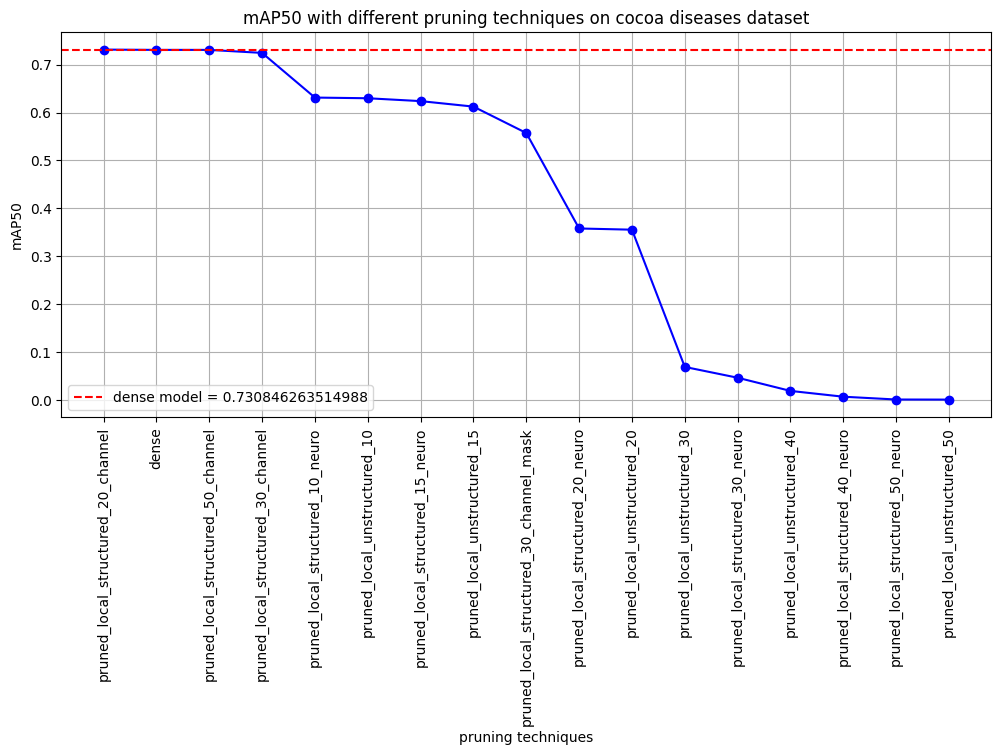

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

df= pd.read_csv("validation_results.csv")
df=df.sort_values(["mAP50"],ascending=False)

x=df["Model_name"]
y=df["mAP50"]

plt.figure(figsize=(12, 5))
plt.plot(x, y, marker="o", linestyle="-", color="b")  # Line plot with markers

# Add a horizontal line corresponding to the value at the third x-point (Mar)
benchmark_value = df["mAP50"][df["Model_name"]=="dense"][0]  # Value at index 2 (Mar)
plt.axhline(y=benchmark_value, color="red", linestyle="--", label=f"dense model = {benchmark_value}")

# Add labels, title, and legend
plt.xlabel("pruning techniques")  # Label for X-axis
plt.ylabel("mAP50")  # Label for Y-axis
plt.title("mAP50 with different pruning techniques on cocoa diseases dataset")  # Title of the plot
plt.legend()  # Show legend

plt.xticks(rotation=90)

# Show the plot
plt.grid(True)  # Optional: Add a grid

plt.savefig("mAP50_results.png",bbox_inches="tight")

plt.show()



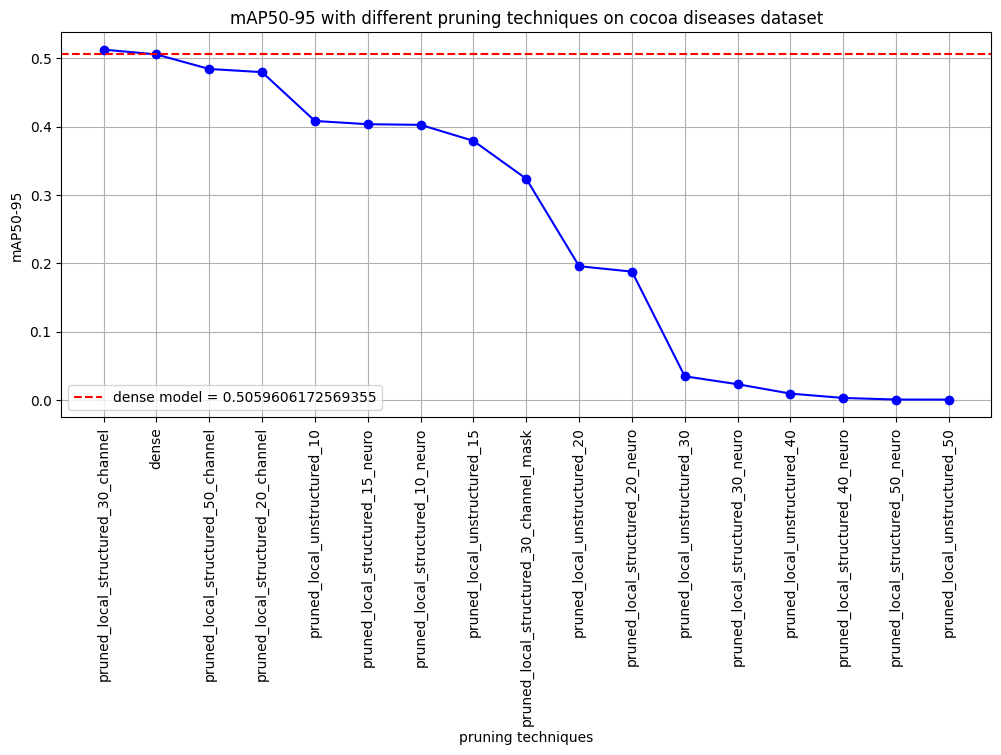

In [40]:
df=df.sort_values(["mAP50_95"],ascending=False)

x=df["Model_name"]
y=df["mAP50_95"]

plt.figure(figsize=(12, 5))
plt.plot(x, y, marker="o", linestyle="-", color="b")  # Line plot with markers

# Add a horizontal line corresponding to the value at the third x-point (Mar)
benchmark_value = df["mAP50_95"][df["Model_name"]=="dense"][0]  # Value at index 2 (Mar)
plt.axhline(y=benchmark_value, color="red", linestyle="--", label=f"dense model = {benchmark_value}")

# Add labels, title, and legend
plt.xlabel("pruning techniques")  # Label for X-axis
plt.ylabel("mAP50-95")  # Label for Y-axis
plt.title("mAP50-95 with different pruning techniques on cocoa diseases dataset")  # Title of the plot
plt.legend()  # Show legend

plt.xticks(rotation=90)

# Show the plot
plt.grid(True)  # Optional: Add a grid

plt.savefig("mAP50-95_results.png",bbox_inches="tight")

plt.show()



